# **Creating the dataset**

In [1]:
#run below code twice
#from line_profiler import LineProfiler
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import percentileofscore

import numpy as np
import pandas as pd
import plotnine as gg
import torch
import torch.optim as optim
from dataloader import TabularDataset

import higher

from torch import nn
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
from polyadic_sampler_classification import *
#import chex
#import haiku as hk
#import jax
#import jax.numpy as jnp
#import optax
import pandas as pd
#import warnings
import gpytorch
from torch.distributions.bernoulli import Bernoulli
#warnings.filterwarnings('ignore')
from enn import *
from pipeline import *

#import pipeline_var_l2_loss
import seaborn as sns
#from dataloader import TabularDataset
#from var_l2_loss_estimator import *
#from ENN import basenet_with_learnable_epinet_and_ensemble_prior
import matplotlib.pyplot as plt

#wandb.init()
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch.nn.init as init
from datetime import datetime
 
#data from https://drive.google.com/drive/u/1/folders/1WuXIzpYLrLNH6pn9zBMx6oRCCQPRz0F1

directory = '/shared/share_mala/data/eicu_train_test/'
train_csv = 'eicu_train_final.csv'
test_csv = 'eicu_test_final.csv'

df_train = pd.read_csv(directory + train_csv)
df_test = pd.read_csv(directory + test_csv)
df = pd.concat([df_train, df_test], axis = 0)
X_col = list(df.columns)[:-1]
Y = 'EVENT_LABEL'
Y_data = np.array(df[Y])

# K-means

In [2]:
# Normalize data
n_cluster = 10
data = np.array(df[X_col])
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
kmeans = KMeans(n_clusters = n_cluster, random_state = 1)
kmeans.fit(data_normalized)

/user/ym2865/.conda/envs/yuanzhe_new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


KMeans(n_clusters=10, random_state=1)

In [3]:
n = df.shape[0]
clusters = kmeans.labels_
centers = kmeans.cluster_centers_

distances = np.linalg.norm(data_normalized - centers[clusters], axis=1)

threshold_list = []
threshold_larger_list = []
for i in range(kmeans.n_clusters):
    cluster_distances = distances[clusters == i]
    #center points
    threshold_list.append(np.percentile(cluster_distances, 0.05))
    threshold_larger_list.append(np.percentile(cluster_distances, 0.5))

n_cluster  = 10
center_ind_list = [[]] * n_cluster
all_data_index_candidate_list = [[]] * n_cluster #candidates, we only want some clusters later


for j in range(n):
    cluster = clusters[j] #retrieve cluster #
    if distances[j] <= threshold_list[cluster]:
        center_ind_list[cluster].append(j)
    if distances[j] <= threshold_larger_list[cluster]:
        all_data_index_candidate_list[cluster].append(j)
        
#compare each cluster
for i in range(kmeans.n_clusters):
    print(i, np.mean(Y_data[clusters == i]))
    
    
train_cluster = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #[0]
test_cluster = [0,6,3,4,2]
pool_cluster = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_whole_index(List, subset):
    res = []
    for j in subset:
        res += List[j]
    return res

train_index = get_whole_index(all_data_index_candidate_list, train_cluster)
test_index = get_whole_index(all_data_index_candidate_list, test_cluster)
pool_index = get_whole_index(all_data_index_candidate_list, pool_cluster)

0 0.05886379192334018
1 0.07463663742307189
2 0.2145539066690506
3 0.06401066844474079
4 0.28399493243243246
5 0.10300429184549356
6 0.7572178477690289
7 0.11015490533562823
8 0.0477972626176219
9 0.03151000177022482


# Save a predictor

In [5]:
#/user/ym2865/Adaptive Sampling/enn_classification
class Neural_Network(torch.nn.Module):    
    # build the constructor
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        # Initialize weights using Gaussian distribution
        init.normal_(self.fc1.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        init.normal_(self.fc2.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        init.normal_(self.fc3.weight, mean=0.0, std=0.01)  # Mean 0, Standard deviation 0.01
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    
X_train = torch.tensor(data[train_index], dtype=torch.float32)
y_train = torch.tensor(Y_data[train_index], dtype=torch.float32) 
y_train = torch.unsqueeze(y_train, -1)
# Hyperparameters
epochs = 500  # Number of training iterations
learning_rate = 0.1

torch.manual_seed(123)

# Model, Loss and Optimizer
model = Neural_Network(input_size=X_train.shape[1], hidden_size = 3, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X_train)
    
    #print test/ pool loss 
    #print X/Y train/ test/ pool
    # Compute and print loss
    loss = criterion(y_pred, y_train)
    if epoch % 10 == 0:  # Print every 10th epoch
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
current_time = datetime.now()
time_str = current_time.strftime("%Y-%m-%d_%H:%M:%S")

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(directory +'predictor/' + 'predictor' +time_str  + '.pt') # Save
print('File_name', 'predictor' +time_str  + '.pt')

Epoch 0, Loss: 0.5295292735099792
Epoch 10, Loss: 0.427507609128952
Epoch 20, Loss: 0.22512461245059967
Epoch 30, Loss: 0.2086227983236313
Epoch 40, Loss: 0.19963735342025757
Epoch 50, Loss: 0.20323722064495087
Epoch 60, Loss: 0.1994781345129013
Epoch 70, Loss: 0.1954740732908249
Epoch 80, Loss: 0.19198310375213623
Epoch 90, Loss: 0.1857200413942337
Epoch 100, Loss: 0.17860546708106995
Epoch 110, Loss: 0.1781260073184967
Epoch 120, Loss: 0.1726360321044922
Epoch 130, Loss: 0.16692723333835602
Epoch 140, Loss: 0.15772239863872528
Epoch 150, Loss: 0.1539110541343689
Epoch 160, Loss: 0.1511954814195633
Epoch 170, Loss: 0.15908893942832947
Epoch 180, Loss: 0.1486889272928238
Epoch 190, Loss: 0.14558281004428864
Epoch 200, Loss: 0.13926784694194794
Epoch 210, Loss: 0.1311279684305191
Epoch 220, Loss: 0.1381109207868576
Epoch 230, Loss: 0.1311144381761551
Epoch 240, Loss: 0.14533820748329163
Epoch 250, Loss: 0.13216979801654816
Epoch 260, Loss: 0.1321280300617218
Epoch 270, Loss: 0.125151097

In [6]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]
    
def ENN_training(x_train, y_train,model_config, enn_config, device, if_print):
    
    dataset_train = TabularDataset(x = x_train, y = y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=model_config.batch_size_train, shuffle=True) 
    sample, label = dataset_train[0]
    input_feature_size = sample.shape[0]  
    
     # to_device
    ENN = basenet_with_learnable_epinet_and_ensemble_prior(input_feature_size, enn_config.basenet_hidden_sizes, model_config.n_classes, enn_config.exposed_layers, enn_config.z_dim, enn_config.learnable_epinet_hiddens, enn_config.hidden_sizes_prior, enn_config.seed_base, enn_config.seed_learnable_epinet, enn_config.seed_prior_epinet, enn_config.alpha).to(device)

    loss_fn_init = torch.nn.CrossEntropyLoss()
    optimizer_init = optim.Adam(ENN.parameters(), lr=model_config.init_train_lr, weight_decay=model_config.init_train_weight_decay)
    # ------- seed for this training
    # ------- train ENN on initial training data  # save the state - ENN_initial_state  # define a separate optimizer for this # how to sample z's ---- separately for each batch
    # ------- they also sampled the data each time and not a dataloader - kind of a bootstrap
    #print('ENN model weights',ENN.learnable_epinet_layers[0].weight)
    enn_loss_list = []
    for i in range(model_config.n_train_init):
        ENN.train()
        for (inputs, labels) in dataloader_train:
            #inputs, labels =  inputs.to(device), labels.to(device)
            z = torch.randn(enn_config.z_dim, device=device)   #set seed for this  #set to_device for this
            optimizer_init.zero_grad()
            outputs = ENN(inputs,z)
             

            labels = torch.tensor(labels, dtype=torch.long, device=device)
            loss = loss_fn_init(input = outputs, target = torch.squeeze(labels))
            if if_print == 1:
                pass
                #print("ENN_init_loss:",loss)
            loss.backward()
            optimizer_init.step()

        enn_loss_list.append(float(loss.detach().to('cpu').numpy())) 
    if if_print == 0:
        plt.plot(list(range(len(enn_loss_list))),enn_loss_list)
        plt.title('ENN loss vs training iter')
        plt.show()
    
    return ENN

class Network(nn.Module):
    def __init__(self, constant_value=1.0, output_size=1):
        super(ConstantValueNetwork, self).__init__()
        # Define the constant value and output size
        #self.constant_value = nn.Parameter(torch.tensor([constant_value]*output_size), requires_grad=False)
        self.output_size = output_size

    def forward(self, x):
        # x is your input tensor. Its value is ignored in this model.
        # Return a 1-D tensor with the constant value for each item in the batch.
        batch_size = x.size(0)  # Get the batch size from the input
        return torch.sigmoid(x)
        #return self.constant_value.expand(batch_size, self.output_size)

Predictor = model_scripted

train_x = torch.tensor(data[train_index], dtype=torch.float32)
train_y_binary = torch.tensor(Y_data[train_index], dtype=torch.float32) 


test_x = torch.tensor(data[test_index], dtype=torch.float32)
test_y_binary = torch.tensor(Y_data[test_index], dtype=torch.float32) 

pool_x = torch.tensor(data[pool_index], dtype=torch.float32)
pool_y_binary = torch.tensor(Y_data[pool_index], dtype=torch.float32) 

Z_dim = 8
if_print = 0

model_cfg = ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [5,5], meta_opt_lr = 0.01, n_classes = 2, n_epoch = 5, init_train_lr = 0.01, init_train_weight_decay = 0.01, n_train_init = 2000, meta_opt_weight_decay = 0.01)
train_config = TrainConfig(n_train_iter = 500, n_ENN_iter = 1000, ENN_opt_lr = 0.01, ENN_opt_weight_decay = 0.01, temp_var_recall = 0.3, z_dim = Z_dim,  N_iter = 20,seed_var_recall = 1 , N_iter_var_recall_est = 100)
enn_cfg = ENNConfig(basenet_hidden_sizes = [50],  exposed_layers = [True], z_dim = Z_dim, learnable_epinet_hiddens = [12], hidden_sizes_prior = [5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_test = TabularDataset(x = test_x, y = test_y_binary)
dataloader_test = DataLoader(dataset_test, batch_size=model_cfg.batch_size_train, shuffle=True) 

# Initial var of recall

/tmp/7446913.1.debian.q/ipykernel_17694/2133377768.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


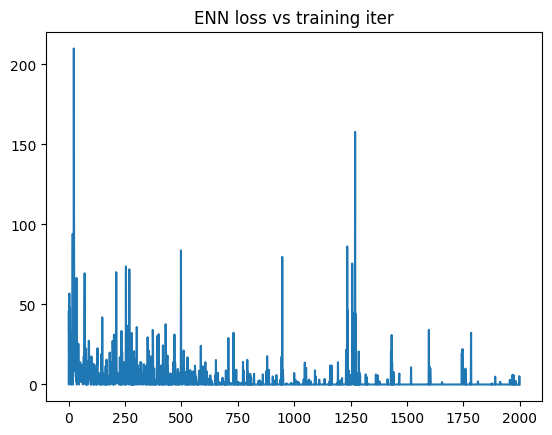

tensor(0., grad_fn=<SubBackward0>)


In [7]:
ENN_trained = ENN_training(train_x, train_y_binary, model_cfg, enn_cfg, device , if_print )
meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
print(meta_loss)

In [12]:
train_y_binary.mean()

tensor(0.0502)

In [9]:
para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est}
var_2(ENN_trained, dataloader_test, Predictor, device, para)

fnet_logits_probs tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

In [8]:
def var_2(fnet, dataloader_test, Predictor, device, para):
    tau = para['tau']
    z_dim = para['z_dim']
    N_iter =  para['N_iter']
    if_print =  para['if_print']
    seed = para['seed_var_recall']
    N_iter_var_recall_est = para['N_iter_var_recall_est']

    torch.manual_seed(seed)

    predicted_class = Model_pred(dataloader_test, Predictor, device) #generate y_pred

    res  = torch.empty((0), dtype=torch.float32, device=device)
    res_square  = torch.empty((0), dtype=torch.float32, device=device)

    
    for i in range(N_iter):
        z_pool = torch.randn(z_dim, device=device)# sample z
        ENN_output_list = torch.empty((0), dtype=torch.float32, device=device)
        for (x_batch, label_batch) in dataloader_test:
            #x_batch = x_batch.to(device)
            #label_batch = label_batch.to(device)
            #shifted z outside from here
            fnet_logits = fnet(x_batch, z_pool) 
            
            #fnet_logits_softmax = torch.nn.Softmax(fnet_logits, dim = 1)
            fnet_logits_probs = torch.nn.functional.softmax(fnet_logits, dim=1)
            print('fnet_logits_probs',fnet_logits_probs)
            ENN_output_list = torch.cat((ENN_output_list,fnet_logits_probs[:,1]),0) 
        #recall est over multiple Gumbel RV
        #print('ENN_output_list',ENN_output_list)
        recall_est_list = torch.empty((0), dtype=torch.float32, device=device)
        for j in range(N_iter_var_recall_est):
            recall_est = Recall(ENN_output_list, predicted_class, tau, seed + j, device).view(1) #use diff seeds for Gumbel
            recall_est_list = torch.cat((recall_est_list, recall_est),0)
        #print("recall_est:", recall_est)
        res = torch.cat((res,torch.mean(recall_est_list).view(1)),0) #append mean of recall over multiple Gumbel
        #print("res:",res)
        res_square = torch.cat((res_square,(recall_est ** 2).view(1)),0)

# After sample cluster centroid points  

In [107]:
# new_train_y_with_pool = torch.cat((train_x, pool_x[pool_sample_idx]), 0)
# new_train_x_with_pool = torch.cat((train_y_binary, pool_y_binary[pool_sample_idx]), 0)


# new_pool_x = pool_x[pool_sample_idx][pool_x[pool_sample_idx] >= 0.25]
# new_pool_x = torch.unsqueeze(new_pool_x,-1)
# new_pool_y = pool_y_binary[pool_sample_idx][torch.squeeze(pool_x[pool_sample_idx] >= 0.25)]
# new_train_y_with_pool = torch.cat((train_x, new_pool_x), 0)
# new_train_x_with_pool = torch.cat((train_y_binary, new_pool_y), 0)


# ENN_trained = ENN_training(new_train_y_with_pool, new_train_x_with_pool, model_cfg, enn_cfg, device , if_print )
# meta_loss = var_recall_estimator(ENN_trained, dataloader_test, Predictor, device, para = {'tau': train_config.temp_var_recall, 'z_dim': train_config.z_dim, 'N_iter': train_config.N_iter ,'if_print':if_print, 'seed_var_recall':train_config.seed_var_recall, 'N_iter_var_recall_est':train_config.N_iter_var_recall_est})     #see where does this calculation for meta_loss happens that is it outside the innerloop_ctx or within it
# print('Var of recall after sampling pool data',meta_loss)